In [1]:
import torch
import torchvision
from torch import nn


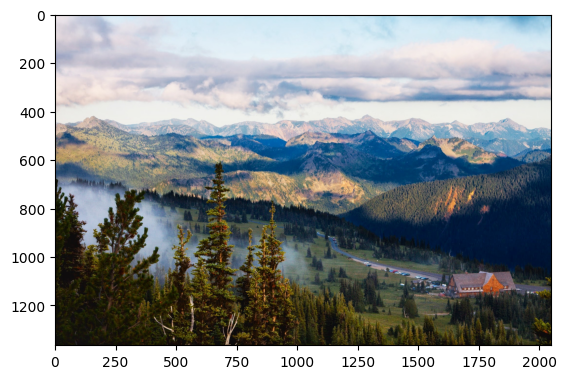

In [3]:
from matplotlib import pyplot as plt 
img = plt.imread("./rainier.jpg")
plt.imshow(img)

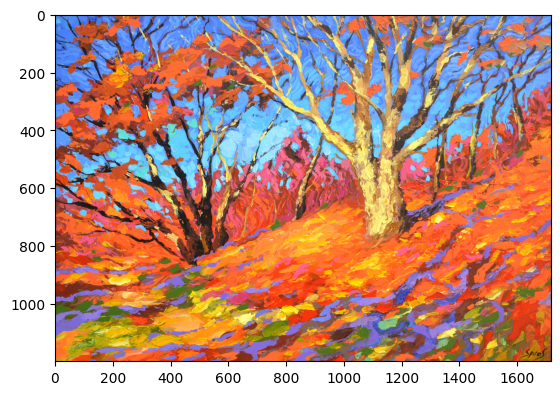

In [4]:
img = plt.imread("./autumn-oak.jpg")
plt.imshow(img)

In [7]:
rgb_mean = torch.tensor([0.485,0.456,0.406])
rgb_std = torch.tensor([0.229,0.224,0.225])

def preprocess(img,img_shape):
    transfor = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(img_shape),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=rgb_mean,std=rgb_std)
        ]
    )
    return transfor(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(
        img.permute(1,2,0) * rgb_std + rgb_mean,0,1
    )
    return torchvision.transforms.ToPILImage()(img.permute(2,0,1))

In [13]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
style_layers,content_layer = [0,5,7],[6]

net = nn.Sequential(
    *[
        list(pretrained_net.children())[i] for i in range(max(content_layer + style_layers) + 1)
    ]
)
def extract_features(X,content_layers,style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)

    return contents,styles

def get_content(img_shape,device,content_img):
    content_X = preprocess(content_img,img_shape).to(device)
    content_Y ,_ = extract_features(content_X,content_layers=content_layer,style_layers=style_layers)
    return content_X,content_Y
def get_styles(img_shape,device,style_img):
    style_x = preprocess(style_img,img_shape).to(device)
    _,styles_Y = extract_features(style_x,content_layer,style_layers)
    return style_x,styles_Y

In [14]:
def content_loss(Y_hat,Y):
    return torch.square(Y_hat - Y.detach()).mean()
def gram(X):
    num_channels , n = X.shape[1],X.numel()
    X = X.resahpe((num_channels,n))
    return torch.matmul(X,X.T) / (num_channels * n)
def style_loss(Y_hat,gram_y):
    return torch.square(gram(Y_hat) - gram_y).detach()

def tv_loss(Y_hat):
    return 0.5*(torch.abs(Y_hat[:,:,1:,:] - Y_hat[:,:,:-1,:]).mean() +
                torch.abs(Y_hat[:,:,:,1:] - Y_hat[:,:,:,:-1]).mean()
                )

In [ ]:
class SynthesizedImage(nn.Module):
    def __init__(self, image_shape,*args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight = nn.Parameter(torch.rand(*image_shape))
    
    def forward(self):
        return self.weight
    
